<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predictive models</a></span><ul class="toc-item"><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#With-smaller-subset-of-data" data-toc-modified-id="With-smaller-subset-of-data-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>With smaller subset of data</a></span><ul class="toc-item"><li><span><a href="#Grid-search" data-toc-modified-id="Grid-search-2.3.1.1"><span class="toc-item-num">2.3.1.1&nbsp;&nbsp;</span>Grid search</a></span></li><li><span><a href="#Hyperopt" data-toc-modified-id="Hyperopt-2.3.1.2"><span class="toc-item-num">2.3.1.2&nbsp;&nbsp;</span>Hyperopt</a></span></li></ul></li><li><span><a href="#With-all-data" data-toc-modified-id="With-all-data-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>With all data</a></span></li></ul></li><li><span><a href="#Support-Vector-Machine" data-toc-modified-id="Support-Vector-Machine-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Support Vector Machine</a></span><ul class="toc-item"><li><span><a href="#Linear-SVM" data-toc-modified-id="Linear-SVM-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Linear SVM</a></span><ul class="toc-item"><li><span><a href="#With-smaller-subset-of-data" data-toc-modified-id="With-smaller-subset-of-data-2.4.1.1"><span class="toc-item-num">2.4.1.1&nbsp;&nbsp;</span>With smaller subset of data</a></span></li><li><span><a href="#Grid-search" data-toc-modified-id="Grid-search-2.4.1.2"><span class="toc-item-num">2.4.1.2&nbsp;&nbsp;</span>Grid search</a></span></li><li><span><a href="#Hyperopt" data-toc-modified-id="Hyperopt-2.4.1.3"><span class="toc-item-num">2.4.1.3&nbsp;&nbsp;</span>Hyperopt</a></span></li><li><span><a href="#Hyperopt" data-toc-modified-id="Hyperopt-2.4.1.4"><span class="toc-item-num">2.4.1.4&nbsp;&nbsp;</span>Hyperopt</a></span></li><li><span><a href="#With-whole-data-set" data-toc-modified-id="With-whole-data-set-2.4.1.5"><span class="toc-item-num">2.4.1.5&nbsp;&nbsp;</span>With whole data set</a></span></li></ul></li><li><span><a href="#SVM-with-RBF-Kernel" data-toc-modified-id="SVM-with-RBF-Kernel-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>SVM with RBF-Kernel</a></span><ul class="toc-item"><li><span><a href="#With-smaller-subset-of-data" data-toc-modified-id="With-smaller-subset-of-data-2.4.2.1"><span class="toc-item-num">2.4.2.1&nbsp;&nbsp;</span>With smaller subset of data</a></span></li><li><span><a href="#With-more-data" data-toc-modified-id="With-more-data-2.4.2.2"><span class="toc-item-num">2.4.2.2&nbsp;&nbsp;</span>With more data</a></span></li></ul></li><li><span><a href="#SVM-with-polynomial-kernel" data-toc-modified-id="SVM-with-polynomial-kernel-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>SVM with polynomial kernel</a></span><ul class="toc-item"><li><span><a href="#With-smaller-subset-of-data" data-toc-modified-id="With-smaller-subset-of-data-2.4.3.1"><span class="toc-item-num">2.4.3.1&nbsp;&nbsp;</span>With smaller subset of data</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance comparison</a></span></li></ul></div>

In [1]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
import missingno  # for visualizing missing data

from hyperopt import hp
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, \
    GridSearchCV, ShuffleSplit

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature


# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 


# Adjust number of CPU cores to use
n_jobs=2

## Preprocessing

In [ ]:
# Load original data
with open('data_processed/all_data.pickle', 'rb') as pickled_file: 
    all_data = pickle.load(pickled_file) 
    
    
# Find categorical variables with more than 50 unique values and drop them
unique_values_cat = all_data.select_dtypes(include='object') \
                        .nunique() \
                        .sort_values(ascending=False) 
# Drop categorical variables with more than 50 categories
all_data = all_data.drop(unique_values_cat[unique_values_cat > 50].index,
                 axis='columns')


def split_preprocess(X=all_data.drop('default', axis='columns'),
                     y=all_data.default,
                     train_size=.8, test_size=.2):
    """
    Splits the data into training and test set of specified size, 
    then applies preprocessing.
    """
    
    # Train-test split 
    # ================
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y,
                         train_size=train_size, test_size=test_size,
                         random_state=1, shuffle=True, stratify=y) 

    # Preprocessing
    # =============
    # Imputation and standardization for numeric features
    numeric_features = X_train.select_dtypes(include=[np.number]).columns
    numeric_transformer = Pipeline(steps =[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())]) 

    # Imputation and one-hot encoding for categorical features
    categorical_features = X_train.select_dtypes(include=[object]).columns
    categorical_transformer = Pipeline(steps =[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Combining preprocessing for both kinds of features
    # (Features of other dtypes – in our case, boolean – will be
    # appended at the end without transformation.)
    # (Use only 1 core to avoid joblib error)
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric_transformer', 
                 numeric_transformer, numeric_features),
            ('categorical_transformer', 
                 categorical_transformer, categorical_features)],
        remainder='passthrough', n_jobs=1) 
    
    # Print dtypes of untransformed data
    print('data types of columns that were not transformed:\n {}'
            .format(X_train.select_dtypes(exclude=[np.number, object]) \
                    .dtypes.unique()))

    # Apply preprocessing
    X_train_p = preprocessor.fit_transform(X_train)
    X_test_p = preprocessor.transform(X_test)
   

    # Get feature names
    # =================
    # Names of categorical variables after one-hot encoding
    categorical_names = preprocessor \
        .named_transformers_['categorical_transformer'] \
        .named_steps['onehot'] \
        .get_feature_names()
    # Names of columns with other dtype (should only be Boolean)
    other_names = X_train \
        .select_dtypes(exclude=[np.number, object]) \
        .columns
    # Concatenate feature names (Note that list with names of 
    # numeric features was already created above)
    feature_names = list(numeric_features) + \
        list(categorical_names) + list(other_names) 

    
    # Return results
    # ==============
    return(X_train_p, X_test_p, y_train, y_test, feature_names)
  
    
# Create smaller training and test data to start out with
X_train_small, X_test_small, y_train_small, y_test_small, feature_names_small= \
    split_preprocess(train_size=20000, test_size=10000)

# Create full training and test set
X_train, X_test, y_train, y_test, feature_names = \
    split_preprocess(train_size=.8, test_size=.2)


# Save preprocessed training and test sets
filenames_whole = ['X_train', 'X_test', 'y_train', 'y_test']
filenames_small = [filename + '_small' for filename in filenames_whole]
filenames = filenames_whole + filenames_small
files = [X_train, X_test, y_train, y_test,
         X_train_small, X_test_small, y_train_small, y_test_small]

for file, filename in zip(files, filenames):
    joblib.dump(file,
                'data_processed/{}.joblib'.format(filename))
# Delete temporary list to conserve memory
del files

# Save feature names
joblib.dump(feature_names, 'data_processed/feature_names')
joblib.dump(feature_names_small, 'data_processed/feature_names_small')

In [2]:
# Load preprocessed training and test set, incl. feature names 
X_train = joblib.load('data_processed/X_train.joblib')
X_test = joblib.load('data_processed/X_test.joblib')
y_train = joblib.load('data_processed/y_train.joblib')
y_test = joblib.load('data_processed/y_test.joblib')
X_train_small = joblib.load('data_processed/X_train_small.joblib')
X_test_small = joblib.load('data_processed/X_test_small.joblib')
y_train_small = joblib.load('data_processed/y_train_small.joblib')
y_test_small = joblib.load('data_processed/y_test_small.joblib')
feature_names = joblib.load('data_processed/feature_names')
feature_names_small = joblib.load('data_processed/feature_names_small')

## Predictive models

In [36]:
# Dictionaries to store results for SMALL data set
average_precision_1 = {}
classification_reports_1 = {}
most_important_features_1 = {} 
# Note that models with small data were estimated on a different subset
# of the observations, though the size stayed constant.  So don't use future 
# importance on these data, unless re-estimating models!

# Dictionaries to store results for WHOLE data set
average_precision_2 = {}
classification_reports_2 = {}
most_important_features_2 = {}

### Random Forests

In [86]:
rf_1 = RandomForestClassifier(n_estimators=100, 
        oob_score=False, n_jobs=n_jobs, random_state=1,
        class_weight='balanced_subsample')
rf_1.fit(X_train_small, y_train_small)

# Predictions of class and probability
y_pred_rf_1 = rf_1.predict(X_test_small) 
y_pred_proba_rf_1 = rf_1.predict_proba(X_test_small)[:, 1]

# Save results
average_precision_1['random forests'] = \
    average_precision_score(y_test_small, y_pred_proba_rf_1)
classification_reports_1['random forests'] = \
    classification_report(y_test_small, y_pred_rf_1)

# Compute feature importance and sort
most_important_features_1['random forests'] = \
    pd.Series(rf_1.feature_importances_, index=feature_names) \
            .sort_values(ascending=False) \
            .iloc[: 10]

In [94]:
import csv
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Function to minimize
def find_best_hp(CLF, space, 
                 X_train, y_train, X_test, y_test,
                 n_folds=5, n_jobs=-1, max_evals=20,
                 progress_file='progress.csv'):
    """Find best hyperparameters for a given classifier and search space."""
    
    def objective(params, CLF=CLF, 
                  n_folds=n_folds, n_jobs=n_jobs):
        """Objective function to minimize"""

        # Instantiate CLF
        clf = CLF(**params)
        
        ## Generate indices is for cross-validation
        # If only one "fold" is desired, split into train and validation set
        if n_folds == 1: 
            cv = StratifiedShuffleSplit(n_splits=1, test_size=.2, 
                                        random_state=1)
        # Otherwise, generate indices for proper cross-validation split
        else:  
            cv = StratifiedKFold(n_folds, random_state=1)

        # Compute average precision through CV / validation set
        score = cross_val_score(clf, X_train, y_train, cv=cv,
                                scoring='average_precision', n_jobs=n_jobs)
        # Compute loss as the negative mean of the average precision scores
        # (since hyperopt can only minimize a function)
        loss = -score.mean()
        
        # Save results to csv file
        with open(progress_file, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([loss, params])
        
        # Return results
        return {'loss': loss, 'params': params, 'status': STATUS_OK}

    # Trials object to track progress
    trials = Trials()

    # CSV file to track progress
    progress_file_connection = open(progress_file, 'w')
    writer = csv.writer(progress_file_connection)

    # Write header to the file
    writer.writerow(['loss', 'params'])
    progress_file_connection.close()

    
    # Minimize objective
    best = fmin(objective, space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials)

    # Get the values of the optimal parameters
    best_params = space_eval(space, best)

    # Fit the model with the optimal hyperparamters
    clf = CLF(**best_params)
    clf.fit(X_train, y_train);

    # Score classifier with the test data
    # Try if classifier supports probability
    try:
        y_score = clf.predict_proba(X_test)[:,1]
    # If it doesn't, use its decision function
    except AttributeError:
        y_score = clf.decision_function(X_test)
    # Calculate average precision
    ap_score = average_precision_score(y_test, y_score)

    # Return best parameters and average precision
    return best_params, ap_score, progress_file

In [96]:
# Calculate the square root of the number of features
sqrt_n_fts = round(np.sqrt(X_train.shape[1]))

# Define hyperparameter search space
space = {
    'class_weight': 'balanced_subsample',
    'random_state': 1,
#     'n_estimators': hp.randint('n_estimators', 10, 250),
    'max_features': hp.randint('max_features', 
                               round(0.5*sqrt_n_fts), 2*sqrt_n_fts)
#     'max_depth': hp.randint('max_depth', 5, 100)
    }
best_p, ap, progress_rf_1 = find_best_hp(
              RandomForestClassifier, space, 
              X_train=X_train_small, y_train=y_train_small,
              X_test=X_test_small, y_test=y_test_small,
              max_evals=10, n_jobs=1)
print(best_p, ap)

TypeError: ap_categorical_sampler() got multiple values for argument 'size'

In [87]:
average_precision_1

{'SVM (RBF Kernel)': 0.38893719706733143,
 'logistic regression': 0.3754287919433627,
 'random forests': 0.3408734704057727}

In [ ]:
from hyperopt import pyll
n_trees_distr = hp.loguniform('n_estimators', -4, 4)
samples = [pyll.stochastic.sample(n_trees_distr) for i in range(100)]
sns.distplot(pd.Series(samples))
# pd.Series(samples).plot(kind='kde')

In [ ]:
pd.Series(samples).describe()

In [ ]:
r = RandomForestClassifier(n_estimators=-1)
r.fit(X_test_small, y_test_small)

###  XGBoost

Since we have a lot of parameters to tune, we need a smart way of searching over the different parameters that avoids the combinatorial explosion that would result from a simultaneous grid search over all parameters.  In the following, I will follow the suggestions from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/.

We will start with a high learning rate to speed up computation, and then determine the ideal number of estimators for this learning rate.  Later, we will tune tree-specific parameters.

In [ ]:
data_xgb_train = xgb.DMatrix(data=X_train_small, label=y_train_small)
data_xgb_test = xgb.DMatrix(data=X_test_small, label=y_test_small)

In [ ]:
    # params = {'objective':'binary:logistic', 'eval_metric':'map',
#          'scale_pos_weight':5,  # Balance class weight
#          'seed':0, 'learning_rate':0.1, 'n_estimators':1000,
#          'max_depth':5, 'min_child_weight':1, 'gamma':0,
#          'subsample':0.8, 'colsample_bytree':0.8,
#          'nthread':4}
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric':'map'
}

N_THREAD = 3
space = {
    'objective':'binary:logistic', 
    'eval_metric':'map',
    'scale_pos_weight':5,  # Balance class weight
    'seed':0, 
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    # A problem with max_depth casted to float instead of int with
    # the hp.quniform method.
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'nthread': N_THREAD,
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
    'seed': random_state
    }
xgb_cv = xgb.train(params=params, dtrain=data_xgb_train, 
                num_boost_round=1000,
                evals=[(data_xgb_test, "test")],
                early_stopping_rounds=50) 
#                 stratified=True, num_boost_round=1000, 
#                 early_stopping_rounds=50, verbose_eval=False,
#                 as_pandas=True, seed=0)

In [ ]:
# Parameters to search over
param_grid = {'max_depth'= [3, 5, 7, 10],  # Control complexity
              'min_child_weight'= , # The higher, the more regularization
              'gamma'= 0, # Higher value leads to fewer splits for a given node (i.e. more regularization) if
              'subsample'= [0.5, 0.75, 1],  # Fraction of observations per tree 
              'colsample_bytree': [0.5, 0.75, 1]} # Fraction of features per tree
# Grid search
xgb_gs_1 = GridSearchCV(xgb_1, param_grid=param_grid, 
                        num_boo
                        scoring='average_precision',
                        return_train_score=True,
                        n_jobs=n_jobs, cv=3, verbose=5)
xgb_gs_1.fit(X_train_small, y_train_small) 

# Save model
joblib.dump(xgb_gs_1, 'saved_models/xgb_gs_1.joblib')

# Predictions
y_proba_xgb = xgb_.predict_proba(X_test_small)[:, 1]
average_precision_score(y_test_small, y_proba_xgb)

In [ ]:
xgb_1 = XGBClassifier(objective='binary:logistic', learning_rate=0.1,
               n_estimators=1000,
               max_depth=5,min_child_weight=1, gamma=0,
               subsample=0.8, colsample_bytree=0.8,
               seed=0, nthread=n_jobs)
xgb_1.fit(X_train_small, y_train_small,
          early_stopping_rounds=50,
          eval_set=[(X_test_small, y_test_small)],
          eval_metric='map'
         )

In [ ]:
# Save model
# joblib.dump(xgb_gs_1, 'saved_models/xgb_gs_1.joblib')

# Predictions
y_proba_xgb = xgb_1.predict_proba(X_test_small)[:, 1]
average_precision_score(y_test_small, y_proba_xgb)

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [ ]:
params = {'objective':'binary:logistic', 'eval_metric':'map',
         'scale_pos_weight':5,  # Balance class weight
         'seed':0}
xgb_cv = xgb.cv(dtrain=data_xgb_train, params=params, nfold=3,
                num_boost_round=50, as_pandas=True)

In [ ]:
y_xgb_cv = xgb_cv.predict(X_test_small)
average_precision_score(y_test_small, y_xgb_cv)

### Logistic regression
#### With smaller subset of data

#####  Grid search

In [ ]:
lr_1 = SGDClassifier(loss='log', penalty='elasticnet', 
                      class_weight='balanced', 
                      max_iter=1000, tol=1E-3, # those are defaults for sklearn 0.21+
                      random_state=1, n_jobs=n_jobs) 

# Parameters to search over
param_grid = {'l1_ratio': np.linspace(0, 1, 11),
              'alpha': np.logspace(-6, 1, 8)}
# Grid search
lr_gs_1 = GridSearchCV(lr_1, param_grid=param_grid, 
                       scoring='average_precision',
                       return_train_score=True,
                       n_jobs=n_jobs, cv=3)
lr_gs_1.fit(X_train_small, y_train_small) 

# Save model
joblib.dump(lr_gs_1, 'saved_models/lr_gs_1.joblib')

In [60]:
# Load model
lr_gs_1 = joblib.load('saved_models/lr_gs_1.joblib')

C:\Users\t\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SGDClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SGDClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [61]:
def gs_best_result(gridsearchcv, decimals=3):
    """Returns details for best results from grid search."""

    # Get mean validation scores
    scores = pd.DataFrame(gridsearchcv.cv_results_) \
                .drop('params', axis='columns')
    
    # Get values for hyperparameters 
    params = pd.DataFrame(
        gridsearchcv.cv_results_['params'])
    
    # Concatenate validation scores and hyperparameters 
    scores_w_params = pd.concat([params, scores], axis=1)
    # Set hyperparameters as index
    scores_w_params = scores_w_params \
                        .set_index(params.columns.tolist())
    
    # Get tuple with best hyperparameters values, making sure it 
    # has the same order as the multi-index.
    best_param_tuple = (
        gridsearchcv.best_params_[scores_w_params.index.names[0]],
        gridsearchcv.best_params_[scores_w_params.index.names[1]])
    
    # Filter results for best hyperparameters 
    best_result = pd.to_numeric(
                    scores_w_params.loc[best_param_tuple, :])
    
    # Return rounded result (convert to dataframe for pretty  printing)
    return(pd.DataFrame(best_result) \
               .round(decimals))

gs_best_result(lr_gs_1)

,0.01
,0.2
mean_fit_time,0.337
std_fit_time,0.067
mean_score_time,0.006
std_score_time,0.001
param_alpha,0.010
param_l1_ratio,0.200
split0_test_score,0.380
split1_test_score,0.394
split2_test_score,0.378


In [62]:
# Predictions
y_pred_lr_1= lr_gs_1.predict(X_test_small)    
y_pred_proba_lr_1= lr_gs_1.predict_proba(X_test_small)[:, 1]

# Save results
average_precision_1['logistic regression'] = \
    average_precision_score(y_test_small, y_pred_proba_lr_1)
classification_reports_1['logistic regression'] = \
    classification_report(y_test_small, y_pred_lr_1)

# Compute feature importance and sort
most_important_features_1['logistic regression'] = \
    pd.Series(lr_gs_1.best_estimator_.coef_[0], 
          index=feature_names_small) \
    .sort_values(ascending=False) \
    .iloc[: 10] 

In [63]:
# Visualize grid search results
def gs_heatmap(gridsearchcv, x_digits=0, y_digits=0,
               x_scientific_notation=True, y_scientific_notation=True):
    """Visualizes validation accuracy from grid search over two hyperparameters."""
    
    # Print test score and  hyperparameters
    print('Best score: {:.3f}, best hyperparameters: '
                .format(gridsearchcv.best_score_), 
          gridsearchcv.best_params_)
      
    # Get mean validation scores
    scores = pd.DataFrame(
        gridsearchcv.cv_results_['mean_test_score'])
    # Get values for hyperparameters
    params = pd.DataFrame(
        gridsearchcv.cv_results_['params'])
    # Concatenate validation scores and hyperparameters 
    scores_w_params = pd.concat([params, scores], 
                                  axis=1)
    # Set first two columns, which correspond to parameters, as index.
    # Then unstack.
    index_cols = list(scores_w_params.columns)[:2]
    scores_2d = scores_w_params.set_index(index_cols) \
                    .squeeze() \
                    .unstack()
    
    # Create desired formatting string for axes (scientific notation and digits)
    if x_scientific_notation == True:
        x_notation = 'E' 
    else: 
        x_notation = 'F'
    x_formatting = '{:.' + str(x_digits) + x_notation + '}'

    if y_scientific_notation == True:
        y_notation = 'E' 
    else: 
        y_notation = 'F'
    y_formatting = '{:.' + str(y_digits) + y_notation + '}'

    # Plot
    fig, ax = plt.subplots()
    sns.heatmap(scores_2d, ax=ax,
                xticklabels=[x_formatting.format(x) for  x in scores_2d.columns],
                yticklabels=[y_formatting.format(y) for y in scores_2d.index])
    ax.set_title('Validation accuracy')
    

Best score: 0.384, best hyperparameters:  {'alpha': 0.01, 'l1_ratio': 0.2}


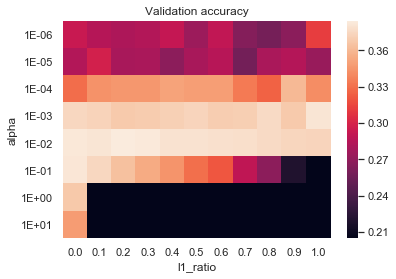

In [64]:
gs_heatmap(lr_gs_1, x_digits=1, x_scientific_notation=False)

In [75]:
average_precision_1

{'SVM (RBF Kernel)': 0.38893719706733143,
 'logistic regression': 0.3754287919433627}

##### Hyperopt

In [94]:
import csv
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Function to minimize
def find_best_hp(CLF, space, 
                 X_train, y_train, X_test, y_test,
                 n_folds=5, n_jobs=-1, max_evals=20,
                 progress_file='progress.csv'):
    """Find best hyperparameters for a given classifier and search space."""
    
    def objective(params, CLF=CLF, 
                  n_folds=n_folds, n_jobs=n_jobs):
        """Objective function to minimize"""

        # Instantiate CLF
        clf = CLF(**params)
        
        ## Generate indices is for cross-validation
        # If only one "fold" is desired, split into train and validation set
        if n_folds == 1: 
            cv = StratifiedShuffleSplit(n_splits=1, test_size=.2, 
                                        random_state=1)
        # Otherwise, generate indices for proper cross-validation split
        else:  
            cv = StratifiedKFold(n_folds, random_state=1)

        # Compute average precision through CV / validation set
        score = cross_val_score(clf, X_train, y_train, cv=cv,
                                scoring='average_precision', n_jobs=n_jobs)
        # Compute loss as the negative mean of the average precision scores
        # (since hyperopt can only minimize a function)
        loss = -score.mean()
        
        # Save results to csv file
        with open(progress_file, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([loss, params])
        
        # Return results
        return {'loss': loss, 'params': params, 'status': STATUS_OK}

    # Trials object to track progress
    trials = Trials()

    # CSV file to track progress
    progress_file_connection = open(progress_file, 'w')
    writer = csv.writer(progress_file_connection)

    # Write header to the file
    writer.writerow(['loss', 'params'])
    progress_file_connection.close()

    
    # Minimize objective
    best = fmin(objective, space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials)

    # Get the values of the optimal parameters
    best_params = space_eval(space, best)

    # Fit the model with the optimal hyperparamters
    clf = CLF(**best_params)
    clf.fit(X_train, y_train);

    # Score classifier with the test data
    # Try if classifier supports probability
    try:
        y_score = clf.predict_proba(X_test)[:,1]
    # If it doesn't, use its decision function
    except AttributeError:
        y_score = clf.decision_function(X_test)
    # Calculate average precision
    ap_score = average_precision_score(y_test, y_score)

    # Return best parameters and average precision
    return best_params, ap_score

In [81]:
# Search space
space = {
    'loss': 'log',
    'penalty': 'elasticnet',
    'class_weight': 'balanced',
    'max_iter': 1000,
    'tol':1E-3,
    'random_state': 1,
    'alpha': hp.loguniform('alpha', -6, 1),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1)
}

# Find best hyperparameters
best_p, ap = find_best_hp(
      SGDClassifier, space, 
      X_train=X_train_small, y_train=y_train_small,
      X_test=X_test_small, y_test=y_test_small,
      max_evals=8*11, n_jobs=3, n_folds=3,
      progress_file='progress_lr.csv')

print(best_p, ap)

{'alpha': 0.007889196976322333, 'class_weight': 'balanced', 'l1_ratio': 0.294037147999564, 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'random_state': 1, 'tol': 0.001} 0.37503654872776293


In [82]:
progress_lr = pd.read_csv('progress_lr.csv')

In [83]:
# Best average precision score on validation set
-progress_lr.loss.min()

0.3839230812564754

We see that the best performance on the test set, 0.378, is slightly higher than what we found with a grid search, .375. Though this difference is only small, but note that this was achieved with the same number of iterations. Thus, let's take a look at how the performance changed with the number of iterations, to see if we already reached a plateau earlier.

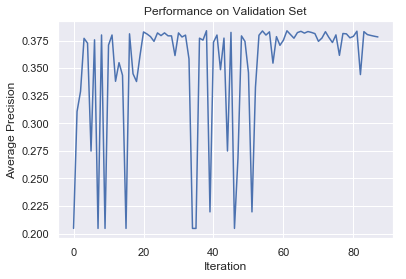

In [84]:
ap = - progress_lr.loss
ap.plot()
plt.title('Performance on Validation Set')
plt.ylabel('Average Precision')
plt.xlabel('Iteration');

This plot shows nicely how the Bayesian search algorithm has an intelligent approach towards the exploration-exploitation dilemma: For the first 20 or so iterations, it focuses on *exploration*: It searches the hyperparameter space seemingly randomly, resulting in both very high and very low performance. Later, it shifts to *exploitation*: Having identified values for the hyperparameters that work well, it shifts to predominantly searching around these values, resulting in more consistent high performance.  Nevertheless, it occasionally shifts back to exploring values further away, in order to avoid getting stuck in a local maximum.

We also see that there does not seem to be much payoff from further optimization once reasonably good values have been found: The best values found during the first 10 iterations are not far off from the overall maximum. Thus, when we ran the hyperparameters optimization on the full data set, we will only let the algorithm run for 40 iteration, since the performance reaches a plateau starting at around 20 iterations.

#### With all data

Let's now estimate the model on all data. Based on the results from the smaller data set, we will adjust the parameter grade for alpha, the constant that multiplies the regularization term: We will drop all values for alpha greater than 0.1, since these did not give us good performance. 

Because we are now using more data, the optimal regularization term will be even smaller; thus, we leave the minimum value for alpha to search over constant, even though it did not give us great performance either on the smaller data. 

In [ ]:
# Logistic regression (Elastic Net) 
# --------------------------------
lr_2 = SGDClassifier(loss='log', penalty='elasticnet', 
                      class_weight='balanced', 
                      max_iter=1000, tol=1E-3, # those are defaults for sklearn 0.21+
                      random_state=1, n_jobs=n_jobs) 

# Parameters to search over
param_grid = {'l1_ratio': np.linspace(0, 1, 11),
              'alpha': np.logspace(-6, 0, 13)}

# Grid search
lr_gs_2 = GridSearchCV(lr_2, param_grid=param_grid, 
                       scoring='average_precision',
                       return_train_score=True,
                       n_jobs=n_jobs, cv=5)
lr_gs_2.fit(X_train, y_train) 

# Save model

joblib.dump(lr_gs_2, 'saved_models/lr_gs_2.joblib')

In [ ]:
# Load model
lr_gs_2 = joblib.load('saved_models/lr_gs_2.joblib')

In [ ]:
# Predictions
y_pred_lr_2 = lr_gs_2.predict(X_test)
y_pred_proba_lr_2 = lr_gs_2.predict_proba(X_test)[:, 1]

# Save results
average_precision_2['logistic regression'] = \
    average_precision_score(y_test, y_pred_proba_lr_2)
classification_reports_2['logistic regression'] = \
    classification_report(y_test, y_pred_lr_2)

In [ ]:
# Compute feature importance and sort
most_important_features_2['logistic regression'] = \
    pd.Series(lr_gs_2.best_estimator_.coef_[0], 
          index=feature_names) \
    .sort_values(ascending=False) \
    .iloc[: 10] 

In [ ]:
lr_1 = SGDClassifier(loss='log', penalty='elasticnet', 
                      class_weight='balanced', 
                      max_iter=1000, tol=1E-3, # those are defaults for sklearn 0.21+
                      random_state=1, n_jobs=n_jobs) 
lr_1.fit(X_train_small, y_train_small).predict(X_train_small).mean()

In [ ]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_small, y_train_small).predict(X_train_small).mean()

In [ ]:
# Visualize grid search results    
gs_heatmap(lr_gs_2, x_digits=1, x_scientific_notation=False)

In [ ]:
print(classification_reports_2['logistic regression'])

### Support Vector Machine
#### Linear SVM

##### With smaller subset of data

##### Grid search

In [ ]:
# Linear SVM
# ----------
# Elastic net, logistic regression (Loss='hinge')
svm_lin_1 = SGDClassifier(loss='hinge', penalty='elasticnet', random_state=1,
                          max_iter=1000, tol=1E-3,
                          class_weight='balanced', n_jobs=n_jobs) 

# Parameters to search over
param_grid = {'l1_ratio': np.linspace(0, 1, 3),
              'alpha': np.logspace(-5, 1, 7)}
svm_lin_gs_1 = GridSearchCV(svm_lin_1, param_grid=param_grid,
                          scoring='average_precision',
                          return_train_score=True,       
                          n_jobs=n_jobs, cv=5)
svm_lin_gs_1.fit(X_train_small, y_train_small)

# Save model
joblib.dump(svm_lin_gs_1, 'saved_models/svm_lin_gs_1.joblib')

In [3]:
### Load model
svm_lin_gs_1 = joblib.load('saved_models/svm_lin_gs_1.joblib')

C:\Users\t\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SGDClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SGDClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
# Prediction of class
y_pred_svm_lin_1 = svm_lin_gs_1.predict(X_test_small)
# Distance from separating hyperplane
y_pred_distance_svm_lin_1 = svm_lin_gs_1.decision_function(X_test_small)

# Save results
average_precision_1['SVM (Linear Kernel)'] = \
    average_precision_score(y_test_small, y_pred_distance_svm_1)
classification_reports_1['SVM (Linear Kernel)'] = \
    classification_report(y_test_small, y_pred_svm_1)

# Visualize grid search results
gs_heatmap(svm_lin_gs_1, x_digits=1, x_scientific_notation=False)

NameError: name 'y_pred_distance_svm_1' is not defined

In [ ]:
average_precision_1

##### Hyperopt

In [81]:

space = {
    'loss': 'log',
    'penalty': 'elasticnet',
    'class_weight': 'balanced',
    'max_iter': 1000,
    'tol':1E-3,
    'random_state': 1,
    'alpha': hp.loguniform('alpha', -6, 1),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1)
}

# Find best hyperparameters
best_p, ap = find_best_hp(
      SGDClassifier, space, 
      X_train=X_train_small, y_train=y_train_small,
      X_test=X_test_small, y_test=y_test_small,
      max_evals=8*11, n_jobs=3, n_folds=3,
      progress_file='progress_lr.csv')

print(best_p, ap)

{'alpha': 0.007889196976322333, 'class_weight': 'balanced', 'l1_ratio': 0.294037147999564, 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'random_state': 1, 'tol': 0.001} 0.37503654872776293


In [82]:
progress_lr = pd.read_csv('progress_lr.csv')

In [83]:
# Best average precision score on validation set
-progress_lr.loss.min()

0.3839230812564754

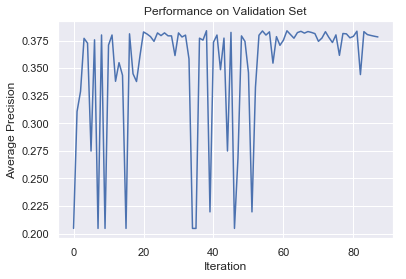

In [84]:
ap = - progress_lr.loss
ap.plot()
plt.title('Performance on Validation Set')
plt.ylabel('Average Precision')
plt.xlabel('Iteration');

##### With whole data set

We will now repeat this analysis on the whole data set. Again, since more data will require less regularization, we will look at lower our maximum value for for to 0.1

In [ ]:
# Linear SVM
# ----------
# Elastic net, logistic regression (Loss='hinge')
svm_lin_2 = SGDClassifier(loss='hinge', penalty='elasticnet', random_state=1,
                          max_iter=1000, tol=1E-3,
                          class_weight='balanced', n_jobs=n_jobs) 

# Parameters to search over
param_grid = {'l1_ratio': np.linspace(0, 1, 11),
              'alpha': np.logspace(-5, -1, 9)}
svm_lin_gs_2 = GridSearchCV(svm_lin_2, param_grid=param_grid,
                          scoring='average_precision',
                          return_train_score=True,       
                          n_jobs=n_jobs, cv=5)
svm_lin_gs_2.fit(X_train, y_train)

# Save model
joblib.dump(svm_lin_gs_2, 'saved_models/svm_lin_gs_2.joblib')

In [ ]:
# Load model
svm_lin_gs_2 = joblib.load('saved_models/svm_lin_gs_2.joblib')

In [ ]:
# Prediction of class
y_pred_svm_2 = svm_lin_gs_2.predict(X_test)
# Distance from separating hyperplane
y_pred_distance_svm_2 = svm_lin_gs_2.decision_function(X_test)

# Save results
average_precision_2['SVM (Linear Kernel)'] = \
    average_precision_score(y_test, y_pred_distance_svm_2)
classification_reports_2['SVM (Linear Kernel)'] = \
    classification_report(y_test, y_pred_svm_2)

# Visualize grid search results
gs_heatmap(svm_lin_gs_2, x_digits=1, x_scientific_notation=False)

#### SVM with RBF-Kernel

##### With smaller subset of data

In [ ]:
svm_rbf_1 = SVC(kernel='rbf', probability=False, 
              cache_size=5000, class_weight='balanced')
# Parameters to search over
param_grid = {'C': np.logspace(-3, 3, 8),
              'gamma': np.logspace(-5, 1, 8)}
# Define indices for validation split (instead of proper cross-validation)
split_indices = ShuffleSplit(n_splits=1, test_size=.2, random_state=1)

svm_rbf_gs_1 = GridSearchCV(svm_rbf_1, param_grid=param_grid,
                          return_train_score=True,
                          scoring='average_precision', cv=split_indices)
svm_rbf_gs_1.fit(X_train_small, y_train_small)

# Save model
joblib.dump(svm_rbf_gs_1, 'saved_models/svm_rbf_gs_1.joblib')

In [37]:
# Load model
svm_rbf_gs_1 = joblib.load('saved_models/svm_rbf_gs_1.joblib')

C:\Users\t\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [38]:
# Prediction of class
y_pred_svm_rbf_1 = svm_rbf_gs_1.predict(X_test_small)

# Distance from separating hyperplane
y_pred_distance_svm_rbf_1 = svm_rbf_gs_1.decision_function(X_test_small)

# Save results
average_precision_1['SVM (RBF Kernel)'] = \
    average_precision_score(y_test_small, y_pred_distance_svm_rbf_1)

classification_reports_1['SVM (RBF Kernel)'] = \
    classification_report(y_test_small, y_pred_svm_rbf_1)

In [ ]:
gs_best_result(svm_rbf_gs_1)

Best score: 0.402, best hyperparameters:  {'C': 0.7196856730011522, 'gamma': 0.003727593720314938}


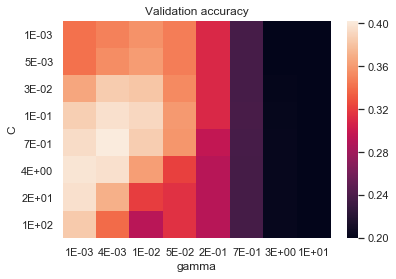

In [42]:
gs_heatmap(svm_rbf_gs_1) #, x_digits=1, x_scientific_notation=False)

In [ ]:
pd.DataFrame(svm_rbf_gs_1.cv_results_)

In [39]:
average_precision_1

{'SVM (RBF Kernel)': 0.38893719706733143}

##### With more data

In [ ]:
svm_rbf_2 = SVC(kernel='rbf', probability=False, 
              cache_size=10000, class_weight='balanced')
# Parameters to search over
param_grid = {'C': np.logspace(-2, 3, 6),
              'gamma': np.logspace(-5, -1, 4)}
# Define indices for validation split (instead of proper cross-validation)
split_indices = ShuffleSplit(n_splits=1, random_state=1,
                             train_size=50000, test_size=1000)

svm_rbf_gs_2 = GridSearchCV(svm_rbf_2, param_grid=param_grid,
                          return_train_score=True, n_jobs=3,
                          scoring='average_precision', cv=split_indices)
svm_rbf_gs_2.fit(X_train, y_train)

# Save model
joblib.dump(svm_rbf_gs_2, 'saved_models/svm_rbf_gs_2.joblib')

In [ ]:
# Load model
svm_rbf_gs_2 = joblib.load('saved_model/svm_rbf_gs_2.joblib')

In [ ]:
# Prediction of class
y_pred_svm_rbf_2 = svm_rbf_gs_2.predict(X_test)

# Distance from separating hyperplane
y_pred_distance_svm_rbf_2 = svm_rbf_gs_2.decision_function(X_test)

# Save results
average_precision_2['SVM (RBF Kernel)'] = \
    average_precision_score(y_test, y_pred_distance_svm_rbf_2)

classification_reports_2['SVM (RBF Kernel)'] = \
    classification_report(y_test, y_pred_svm_rbf_2)

In [ ]:
gs_best_result(svm_rbf_gs_2)

In [ ]:
gs_heatmap(svm_rbf_gs_2, x_digits=1, x_scientific_notation=False)

In [ ]:
pd.DataFrame(svm_rbf_gs_2.cv_results_)

#### SVM with polynomial kernel 

##### With smaller subset of data

In [ ]:
svm_poly = SVC(kernel='poly', probability=False, gamma='auto',
              cache_size=5000, class_weight='balanced')
# Parameters to search over
param_grid = {'C': np.logspace(-3, 3, 8),
              'degree': [2,3,4]}
# Define indices for validation split (instead of proper cross-validation)
split_indices = ShuffleSplit(n_splits=1, test_size=.2, random_state=1)

svm_poly_gs = GridSearchCV(svm_poly, param_grid=param_grid,
                          return_train_score=True,
                          scoring='average_precision', cv=split_indices)
svm_poly_gs.fit(X_train_p, y_train)

In [ ]:
# Prediction of class
y_pred_svm_poly = svm_poly_gs.predict(X_test_p)

# Distance from separating hyperplane
y_pred_distance_svm_poly = svm_poly_gs.decision_function(X_test_p)

# Save results
average_precision['SVM (Polynomial Kernel)'] = \
    average_precision_score(y_test, y_pred_distance_svm_poly)

classification_reports['SVM (Polynomial Kernel)'] = \
    classification_report(y_test, y_pred_svm_poly)

In [ ]:
gs_heatmap(svm_poly_gs, x_scientific_notation=False)

In [ ]:
# Save model
joblib.dump(svm_poly_gs, 'svm_poly_gs.joblib')

## Performance comparison

In [ ]:
average_precision

In [ ]:
average_precision = 
plt.title('Impact of Dropping Columns on Classifier Performance')
plt.ylabel('Average Precision');